In [1]:
import os
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
import Lasso.lasso_model as Lasso
import PCR.PCR_model as PCR
import Random_Forrest.rf_model as RF
import XGBoost.xgboost_model as XGBoost

#  Case Study: Forecasting Inflation During the COVID-19 Shock

This notebook presents a focused evaluation of model performance during the COVID-19 period. We simulate how different forecasting models would have predicted inflation for 2022, using only data available up to the end of 2021. The case study offers insights into how robust the models are under economic shocks and whether they provide valuable input for policy and forecasting in uncertain times.

## Structure of the Notebook

---

### 1. **Data and Preprocessing**
* Load and preprocess the macroeconomic dataset (`merged_dataset.csv`).
* Import inflation forecasts published by the **Danish National Bank** in **March 2022** and **September 2022**.
* **Target variable**: Year-over-year inflation.
* **Explanatory variables**: A comprehensive set of macroeconomic indicators.

### 2. **12-Month Ahead Forecast Case (Historical Simulation)**
For each point in time — **March 2022** and **September 2022** — the models produce 12-month-ahead inflation forecasts, which are compared to actual outcomes and the corresponding National Bank projections.

#### 2.1 Forecast Plots

* **Forecast from March 2022**: Models vs. National Bank forecast, for March 2022 to February 2023.
* **Forecast from September 2022**: Models vs. National Bank forecast, for September 2022 to August 2023.


#### 2.2 Forecast Evaluation

* Evaluate predictive performance for **each forecast origin** (March and September) using:

  * **Root Mean Squared Error (RMSE)**
  * **Mean Absolute Error (MAE)**
* Comparison of:
  * Each model’s forecast errors
  * National Bank’s forecast errors
---

## Objective of the Notebook

The goal is:  
**To demonstrate how machine learning forecasting models can be applied in practice to support economic decision-making during periods of uncertainty and structural change.**



# 1. Data and Preprocessing

In [5]:
# Navigate to data folder
os.chdir('Data')

# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 276)


In [6]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 275)


### Inflation forecasts by the **Danish National Bank** 

In [8]:
file_path = 'Nb_forudsigelser.xlsx'
NB_forecast = pd.read_excel(file_path, header=0, decimal=",")
NB_forecast

,År,Forudsigelse,Horisont,Prognose udgivelse
0,2015,0.5,0,2015-03-01
1,2016,1.8,1,2015-03-01
2,2017,1.9,2,2015-03-01
3,2015,0.3,0,2015-09-01
4,2016,1.3,1,2015-09-01
...,...,...,...,...
58,2025,2.1,1,2024-09-01
59,2026,1.8,2,2024-09-01
60,2025,2.0,0,2025-03-01
61,2026,1.7,1,2025-03-01


# Functions

In [10]:
def run_all_forecasters(X, y, forecast_horizon, last_observation_date, scaler, trees, window_length=108, verbose=True):
    """
    Run LASSO, XGBoost, PCR, and Random Forest forecasters and combine their forecasts in one DataFrame.

    Args:
        X: DataFrame of predictors
        y: Series of the target variable
        forecast_horizon: int, number of steps ahead to forecast
        last_observation_date: str or pd.Timestamp, origin date for forecasting
        scaler: fitted sklearn scaler
        trees: int, number of trees for Random Forest
        window_length: int, size of the rolling window (default: 108 months)
        verbose: bool, whether to print model details
    Returns:
        pd.DataFrame with forecasts from all models and the true inflation values
    """

    # --- Run LASSO ---
    lasso_df = Lasso.lasso_forecast(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    lasso_df.rename(columns={"Inflation forecast": "LASSO"}, inplace=True)

    # --- Run XGBoost ---
    xgb_df = XGBoost.XGBoost_Forecaster(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    xgb_df.rename(columns={"Inflation forecast": "XGBoost"}, inplace=True)

    # --- Run PCR ---
    pcr_df = PCR.pcr_forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        variance_threshold=0.95,
        window_length=window_length,
        verbose=verbose
    )
    pcr_df.rename(columns={"Inflation forecast": "PCR"}, inplace=True)

    # --- Run Random Forest ---
    rf_df = RF.RandomForest_Forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        trees=trees,
        window_length=window_length,
        verbose=verbose
    )
    rf_df.rename(columns={"Inflation forecast": "RandomForest"}, inplace=True)

    # --- Merge all forecasts ---
    combined_df = lasso_df[["Date", "Horizon", "LASSO"]] \
        .merge(xgb_df[["Date", "Horizon", "XGBoost"]], on=["Date", "Horizon"]) \
        .merge(pcr_df[["Date", "Horizon", "PCR"]], on=["Date", "Horizon"]) \
        .merge(rf_df[["Date", "Horizon", "RandomForest"]], on=["Date", "Horizon"])

    # --- Add y_true column ---
    combined_df["y_true"] = combined_df["Date"].apply(
    lambda d: y.loc[d] if d in y.index else np.nan
    )

    return combined_df

# Evaluate forecast error using a selected metric
def evaluate(df, metric):
    # List of model names to evaluate (these must be columns in df)
    models = ["LASSO", "XGBoost", "PCR", "RandomForest", "Danmarks_NB"]
    
    # If metric is RMSE (Root Mean Squared Error), compute for each model
    if metric == "RMSE":
        return {
            model: np.sqrt(mean_squared_error(df["y_true"], df[model]))
            for model in models
        }

    # If metric is MAE (Mean Absolute Error), compute for each model
    if metric == "MAE":
        return {
            model: mean_absolute_error(df["y_true"], df[model])
            for model in models
        }


In [11]:
def plot_forecast(df, title, forecast_origin=None, save_path=None):
    # Create figure and axis with tight layout
    fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

    # Define colors and marker styles for each model
    model_styles = {
        "LASSO":        {"color": "#bc5090", "marker": "o"},
        "XGBoost":      {"color": "#ff7f0e", "marker": "s"},
        "PCR":          {"color": "#2ca02c", "marker": "^"},
        "RandomForest": {"color": "#d62728", "marker": "d"}
    }

    # Plot National Bank forecast (assumed constant)
    nb_val = df["Danmarks_NB"].iloc[0]
    ax.plot(df["Date"], [nb_val] * len(df),
            label="Danish National Bank",
            color="#005f99",
            linewidth=3.0)

    # Plot actual inflation
    ax.plot(df["Date"], df["y_true"],
            label="Actual Inflation",
            color="black",
            linewidth=2.5)

    # Plot model forecasts with dashed lines and markers
    for model, style in model_styles.items():
        ax.plot(df["Date"], df[model],
                label=model,
                color=style["color"],
                linestyle="--",
                marker=style["marker"],
                markersize=7,
                markerfacecolor=style["color"],
                markeredgecolor=style["color"],
                linewidth=1.8)

    # Add vertical line marking forecast origin (if provided)
    if forecast_origin:
        ax.axvline(pd.Timestamp(forecast_origin), color="gray", linestyle=":", linewidth=1.2)
        ax.text(pd.Timestamp(forecast_origin), ax.get_ylim()[1], " Forecast start",
                color="gray", fontsize=9, va="top", ha="left")

    # Axes and style
    ax.set_title(title, fontsize=13, weight="bold")
    ax.set_xlabel("Forecast Target Month")
    ax.set_ylabel("Inflation Rate (%)")
    max_y = max(df[["LASSO", "XGBoost", "PCR", "RandomForest", "y_true"]].max())
    rounded_max = np.ceil(max_y + 1)
    ax.set_ylim(0, rounded_max)
    ax.set_yticks(np.arange(0, rounded_max + 1, 2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle=":", alpha=0.7)

    # Move legend to the right side of the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Figure saved to: {save_path}")

    plt.show()

    

In [12]:
def plot_combined_forecasts(df_march, df_sept, title="Forecast Comparison: March vs September", save_path=None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np

    fig, ax = plt.subplots(figsize=(13, 6))

    # Plot actual inflation
    ax.plot(df_march["Date"], df_march["y_true"], color="black", label="Actual Inflation", linewidth=2.5)

    # Mark forecast origin dates
    ax.axvline(pd.Timestamp("2022-03-01"), color="gray", linestyle=":", linewidth=1)
    ax.axvline(pd.Timestamp("2022-09-01"), color="gray", linestyle=":", linewidth=1)
    ax.text(pd.Timestamp("2022-03-01"), ax.get_ylim()[1] - 1, "March Forecast Start", color="gray", fontsize=8, va="top")
    ax.text(pd.Timestamp("2022-09-01"), ax.get_ylim()[1] - 1.5, "September Forecast Start", color="gray", fontsize=8, va="top")

    # Define model styles
    model_styles = {
        "LASSO": {"color": "#bc5090", "marker": "o"},
        "XGBoost": {"color": "#ff7f0e", "marker": "s"},
        "PCR": {"color": "#2ca02c", "marker": "^"},
        "RandomForest": {"color": "#d62728", "marker": "d"}
    }

    # Plot each model's forecasts for both March and September
    for model, style in model_styles.items():
        if model in df_march.columns:
            ax.plot(df_march["Date"], df_march[model],
                    label=f"{model} (Mar)",
                    linestyle="--",
                    marker=style["marker"],
                    color=style["color"],
                    markersize=6,
                    markerfacecolor=style["color"],
                    markeredgecolor=style["color"],
                    linewidth=1.5)

        if model in df_sept.columns:
            ax.plot(df_sept["Date"], df_sept[model],
                    label=f"{model} (Sep)",
                    linestyle="-.",
                    marker=style["marker"],
                    color=style["color"],
                    markersize=6,
                    markerfacecolor="white",
                    markeredgecolor=style["color"],
                    linewidth=1.5)

    # Axes and style
    ax.set_title(title, fontsize=13, weight="bold")
    ax.set_ylabel("Inflation Rate (%)")
    ax.set_xlabel("Forecast Target Month")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle=":", alpha=0.7)

    # Legend to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

    # Save figure if needed
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")
        print(f"✅ Saved to {save_path}")

    plt.tight_layout()
    plt.show()

# Forecasting Inflation in 2022: Historical Simulation

In [14]:
# Forecast from March 2022 (i.e., using data up to end-February to predict April 2022 to March 2023)
forecast_march = run_all_forecasters(
    X, y,
    forecast_horizon=12,
    last_observation_date="2022-02-01",
    scaler=scaler,
    trees=100,
    window_length=108,
    verbose=False
)

# Forecast from September 2022 (i.e., using data up to end-August to predict October 2022 to September 2023)
forecast_sept = run_all_forecasters(
    X, y,
    forecast_horizon=12,
    last_observation_date="2022-08-01",
    scaler=scaler,
    trees=100,
    window_length=108,
    verbose=False
)

#### Include benchmarks 

In [16]:
nb_march_2022 = NB_forecast[NB_forecast["Prognose udgivelse"] == "2022-03-01"]
nb_sept_2022 = NB_forecast[NB_forecast["Prognose udgivelse"] == "2022-09-01"]

In [17]:
forecast_march["Danmarks_NB"] = nb_march_2022[nb_march_2022["Horisont"] == 0]["Forudsigelse"].values[0]
forecast_sept["Danmarks_NB"] = nb_sept_2022[nb_sept_2022["Horisont"] == 0]["Forudsigelse"].values[0]

In [18]:
forecast_march

,Date,Horizon,LASSO,XGBoost,PCR,RandomForest,y_true,Danmarks_NB
0,2022-03-01,0,4.791111,4.797470,4.523130,4.32885,5.369,5.4
1,2022-04-01,1,3.174241,4.708389,3.513591,3.61783,6.686,5.4
2,2022-05-01,2,1.659975,4.297191,3.423572,3.27622,7.436,5.4
3,2022-06-01,3,2.431892,4.256414,3.792353,3.60849,8.190,5.4
4,2022-07-01,4,3.948186,3.469549,3.349812,3.51697,8.704,5.4
5,2022-08-01,5,2.673923,4.238636,3.399650,3.34629,8.910,5.4
6,2022-09-01,6,3.495550,4.791649,3.454669,3.39063,10.019,5.4
7,2022-10-01,7,2.422539,3.313912,2.987676,3.53727,10.112,5.4
8,2022-11-01,8,2.202674,3.391205,3.079411,3.57651,8.870,5.4
9,2022-12-01,9,3.555761,4.081832,3.118715,3.34729,8.724,5.4


In [19]:
forecast_sept

,Date,Horizon,LASSO,XGBoost,PCR,RandomForest,y_true,Danmarks_NB
0,2022-09-01,0,8.908718,8.909632,8.780218,8.50007,10.019,8.6
1,2022-10-01,1,9.401614,8.347878,8.292136,7.76449,10.112,8.6
2,2022-11-01,2,10.552998,8.245733,8.779513,7.95035,8.870,8.6
3,2022-12-01,3,8.015652,7.484787,9.095056,7.35121,8.724,8.6
4,2023-01-01,4,8.728538,7.935754,9.539837,6.96841,7.678,8.6
5,2023-02-01,5,11.205231,7.556112,10.268435,7.43028,7.601,8.6
6,2023-03-01,6,12.527819,8.769726,11.059144,7.33251,6.733,8.6
7,2023-04-01,7,15.323312,8.398147,10.545800,7.12417,5.282,8.6
8,2023-05-01,8,8.551328,8.186882,10.601476,7.52897,2.928,8.6
9,2023-06-01,9,8.683705,7.355387,9.135902,7.43840,2.465,8.6


## 2.1 Forecast Plots

### **Forecast from March 2022**

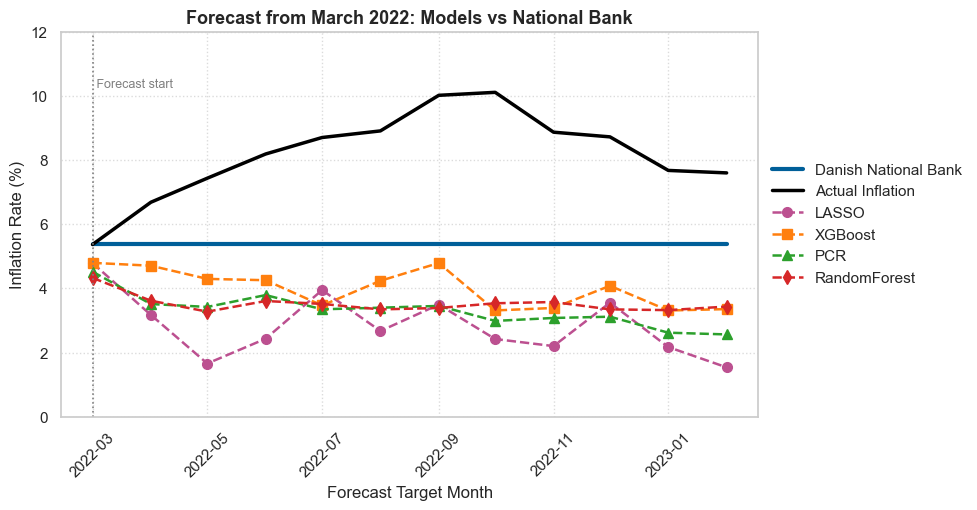

In [22]:
plot_forecast(
    forecast_march,
    title="Forecast from March 2022: Models vs National Bank",
    forecast_origin="2022-03-01",
    #save_path="forecast_march.png" 
)


### **Forecast from September 2022**

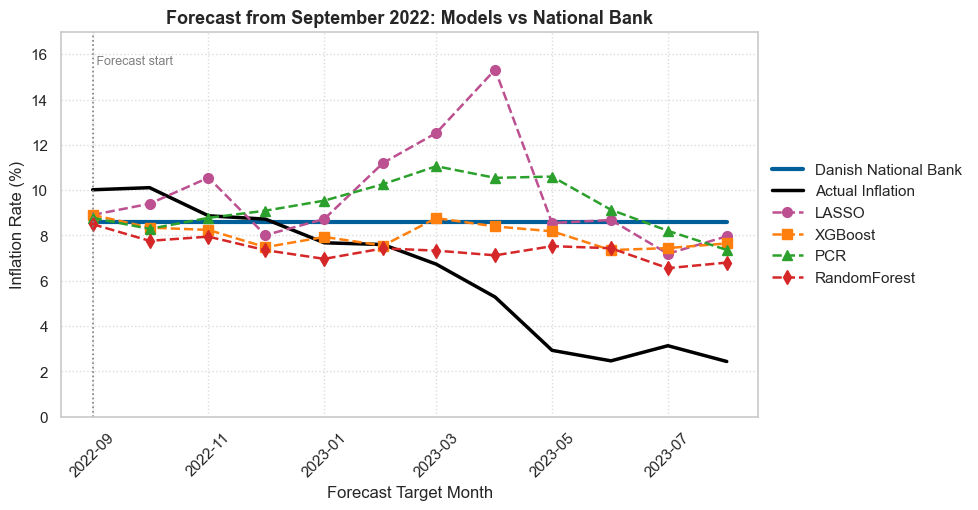

In [24]:
plot_forecast(
    forecast_sept,
    title="Forecast from September 2022: Models vs National Bank",
    forecast_origin="2022-09-01",
    #save_path="forecast_sept.png" 
)

### A combined plot

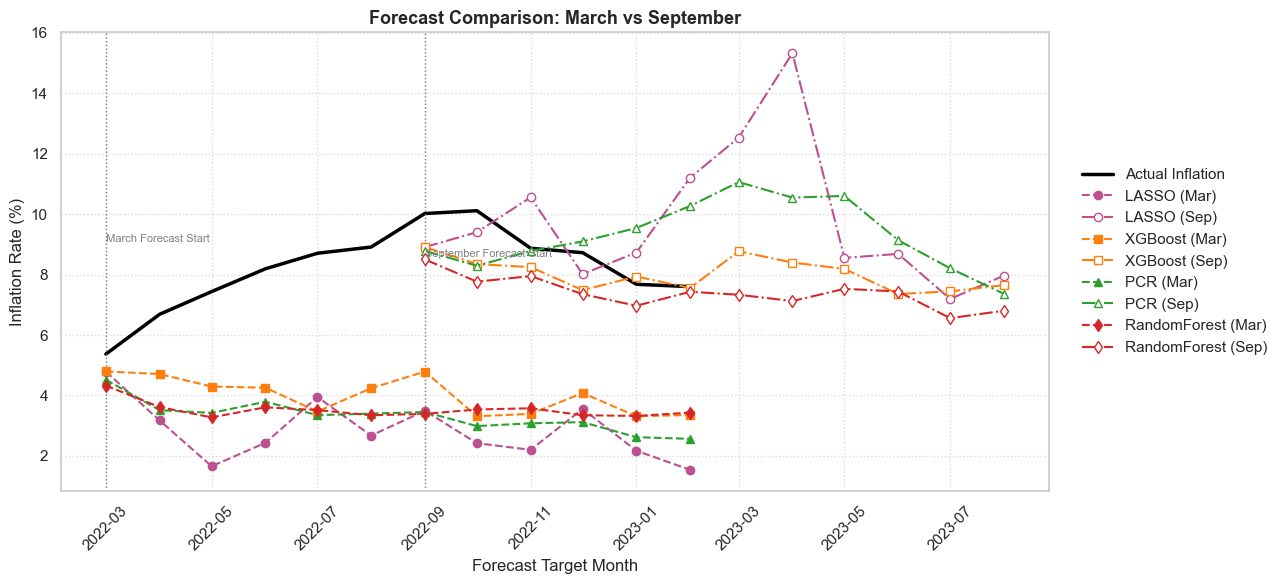

In [26]:
plot_combined_forecasts(forecast_march, forecast_sept)

## 2.2 Forecast Evaluation

### **Forecast Erros: RMSE**

In [29]:
# Evaluate RMSE for forecasts from March and September
rmse_march = evaluate(forecast_march, metric="RMSE")
rmse_sept = evaluate(forecast_sept, metric="RMSE")

# Create a DataFrame with models as index
RMSE_df = pd.DataFrame({
    "March 2022 Forecast": rmse_march,
    "September 2022 Forecast": rmse_sept
})

# Round the values for cleaner output
RMSE_df = RMSE_df.round(3)

# Display the results
RMSE_df

,March 2022 Forecast,September 2022 Forecast
LASSO,5.632,4.751
XGBoost,4.481,3.130
PCR,5.123,4.237
RandomForest,4.891,2.762
Danmarks_NB,3.075,3.633


### **Forecast Erros: MAE**

In [31]:
# Evaluate MAE for forecasts from March and September
mae_march = evaluate(forecast_march, metric="MAE")
mae_sept = evaluate(forecast_sept, metric="MAE")

# Create a DataFrame with models as index
mae_df = pd.DataFrame({
    "March 2022 Forecast": mae_march,
    "September 2022 Forecast": mae_sept
})

# Round the values for cleaner output
mae_df = mae_df.round(3)

# Display the results
mae_df

,March 2022 Forecast,September 2022 Forecast
LASSO,5.353,3.844
XGBoost,4.190,2.489
PCR,4.872,3.499
RandomForest,4.666,2.237
Danmarks_NB,2.797,2.822
